# Gaussian Mixture Model
Hasti Hojabr \
ID : 97216040\
Proffesor: Marzie Farhang\
Course: Statics, Probability and Data Analysis @ Shahid Beheshti University \
Date: June 8,2022

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import warnings
from IPython.display import display, HTML
warnings.filterwarnings("ignore")

In [2]:
from matplotlib.patches import Ellipse
from scipy.stats import multivariate_normal
from sklearn.datasets import make_blobs
from matplotlib.pyplot import cm
from sklearn.metrics import silhouette_score
from sklearn.model_selection import train_test_split
from sklearn import metrics

## 2 High Dimensional GMM

### 2.1 Expectation Maximization Algorithm 

In [3]:
def GMM_ND(X,k,iterations,check,radius):
    
    def Expectation(X,means,variances): 
        r = [] ; r_norm=[] ;     cc = 1e-6*np.identity(len(X[0]))

        for i in range(k): 
            if covs[i,0,0]==0 or covs[i,1,1]==0: covs[i,0,0] = 1e-5 ; covs[i,1,1] = 1e-5 

            r.append(multivariate_normal.pdf(X, means[i],covs[i]))

        r = np.array(r)  
        for j in range(k): r_norm.append((r[j])/(np.sum([r[i] for i in range(k)], axis=0)))

        return np.array(r_norm),np.sum([r[i] for i in range(k)], axis=0)  #responsibility r_nk, likelihood


    def Maximization(r,means,variances,pi):

        for i in range(k):
            Nk       = np.sum(r[i,:],axis=0)        # Σ r_nk
            m        = r[i,:].reshape(len(X),1) *X 
            means[i] = np.sum(r[i,:].reshape(len(X),1) *X,axis=0)/Nk          # 1/Nk Σ r_nk * x_n
            pi[i]    = Nk/len(X)                    # Nk/N
            covs[i]  = (np.dot(np.transpose(r[i,:].reshape(len(X),1)*(X-means[i])),(X-means[i])))/Nk  # 1/Nk Σ r_nk * (x_n-mean_k).(x_n-mean_k)^T
        return means,covs,pi


    def Principal_axes(pos,cov):
        U, S, Vt = np.linalg.svd(cov)   #Cov = US(V^T)  S contains eigenvalues

        #print('Not Diag Form',covariance)
        #print('********')
        #print('Diag Form',U*np.diag(S)*Vt)

        width, height = 2 * np.sqrt(S)
        angle = np.arctan2(U[1, 0], U[0, 0]) * 180/np.pi

        return width, height,angle

    def Gaussian_plot(X,means,covariances,pis,radius,ax):

        
        c = cm.winter(np.linspace(0, 1, len(pis))) #colors
        
        for loc, cov,color in zip(means,covariances,c):
            width,height,angle = Principal_axes(loc,cov)

            for i in radius: ax.add_patch(Ellipse(loc, i*width, i*height, angle,
                                                      alpha=0.2,color=color)) 
        ax.scatter(X[:, 0], X[:, 1],color='k')

    #Initialize the hidden variables
    means = np.random.uniform(np.min(X),np.max(X),size=(k,2))
    covs  = np.array([np.identity(2).tolist() for n in range(k)])
    pi    = np.repeat(1/k,k)

    fig = plt.figure(figsize=(18, 8))
    log_likelihood = np.zeros(iterations)
    axis=1
    for iterr in range(iterations):

        r,likelihood  = Expectation(X,means,covs)       #E step
        means,covs,pi = Maximization(r,means,covs,pi)   #M step

        log_likelihood[iterr] = np.log(np.sum(likelihood)) #Log of likelihood. Its used for convergence. 

        if iterr in [0,2,(iterations-1)//2,iterations-1]: 
            
            ax =  fig.add_subplot(2, 2, axis )
            Gaussian_plot(X,means,covs,pi,radius,ax)
            plt.title('Iteration {}/{}'.format(iterr,iterations-1))
            axis+=1
        
    return means,covs,log_likelihood,pi


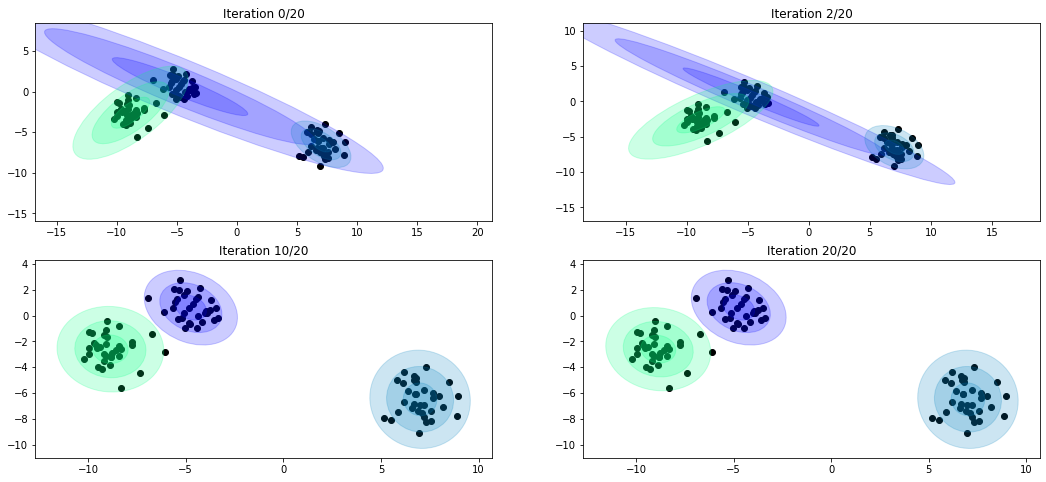

In [5]:
X, y  = make_blobs(random_state=15)  # generate synthetic two-dimensional data
k     = 3

means,covs,log_likelihood,pi = GMM_ND(X,k,21,20,range(1,4))


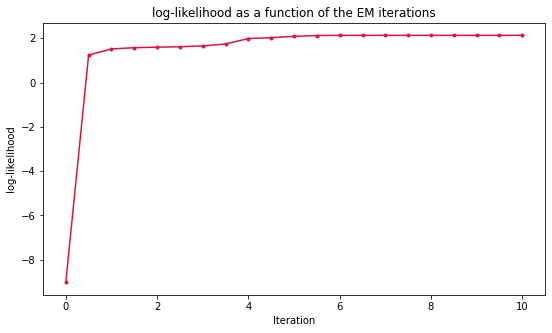

In [6]:
fig = plt.figure(figsize=(9, 5))
x=np.linspace(0,10,len(log_likelihood[:40]))

plt.plot(x,log_likelihood[:40],color='crimson',marker='.')
plt.xlabel('Iteration') ; plt.ylabel(' log-likelihood ')
plt.title('log-likelihood as a function of the EM iterations')
plt.show()

### 2.1 Using Sklearn

In [7]:
from sklearn.mixture import GaussianMixture  

def GMM_sklearn_Nd(x,k,iterations):
    
    GMM = GaussianMixture(n_components = k, max_iter=iterations, random_state=10, covariance_type = 'full')
    
    means = GMM.fit(x).means_  
    covs  = GMM.fit(x).covariances_
    pi    = GMM.fit(x).weights_
    label = GMM.predict(x)
    
    return means,covs,pi,label


In [8]:
def Principal_axes(pos,cov):
    U, S, Vt = np.linalg.svd(cov)   #Cov = US(V^T)  S contains eigenvalues

    #print('Not Diag Form',covariance)
    #print('********')
    #print('Diag Form',U*np.diag(S)*Vt)
    
    width, height = 2 * np.sqrt(S)
    angle = np.arctan2( U[0, 0],U[1, 0]) * 180/np.pi

    return width, height,angle

def Gaussian_plot(X,labels,means,covariances,pis,radius):
    fig = plt.figure(figsize=(9, 5))
    ax = fig.add_subplot(111)

    c = cm.winter(np.linspace(0, 1, len(pis))) #colors
    
    if type(X)==pd.core.frame.DataFrame:
        mglearn.discrete_scatter(X.iloc[:, 0], X.iloc[:, 1], labels, s=7, markers='o',c=c)
    else: 
        mglearn.discrete_scatter(X[:, 0], X[:, 1], labels, s=7, markers='o',c=c)
    for loc, cov,color in zip(means,covariances,c):
        width,height,angle = Principal_axes(loc,cov)

        for i in radius: ax.add_patch(Ellipse(loc, i*width, i*height, angle,
                                                  alpha=0.2,color=color)) 
    plt.title('GMM for {} clusters.'.format(len(means)))
        

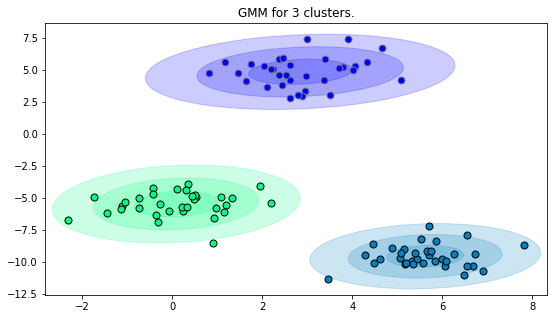

In [9]:
from sklearn.datasets import make_blobs
import mglearn

X, y = make_blobs(random_state=10)  # generate synthetic two-dimensional data

means,covs,pi,label = GMM_sklearn_Nd(X,3,100)
Gaussian_plot(X,label,means,covs,pi,range(1,4))

In [10]:
from sklearn.mixture import GaussianMixture  

def BIC_AIC(X,max_k):

    GMM = []
    for k in range(1,max_k+1):
        GMM.append(GaussianMixture(n_components = k, max_iter=10000, random_state=10, covariance_type='full').fit(X)) 
    
    BIC=[] ; AIC=[]
    for gmm in GMM:
        BIC.append(gmm.bic(X))
        AIC.append(gmm.aic(X))
    
    fig = plt.figure(figsize=(9, 5))
    plt.plot(range(1,max_k+1),BIC,color='darkblue',marker='.',label='BIC',lw=2)
    plt.plot(range(1,max_k+1),AIC,color='crimson',marker='.',label='AIC',lw=2)
    plt.xlabel('Number of Clusters ')
    plt.title('BIC & AIC')
    plt.show()
    
    optimal_BIC = np.argmin(np.array(BIC))+1 ; optimal_AIC = np.argmin(np.array(BIC))+1
    
    print('The optimal number of clusters is {} using BIC.'.format(optimal_BIC))
    print('The optimal number of clusters is {} using AIC.'.format(optimal_AIC))


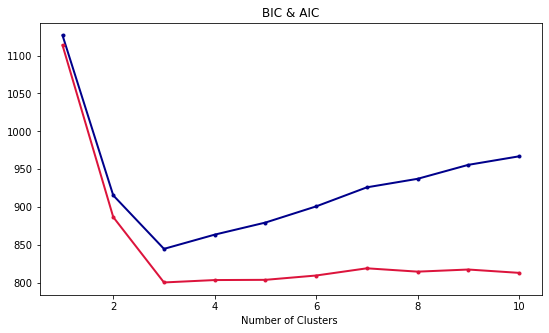

The optimal number of clusters is 3 using BIC.
The optimal number of clusters is 3 using AIC.


In [11]:
BIC_AIC(X,10)